# Fuzzy ARTMAP com classes ordenadas

## Importando bibliotecas

In [41]:
%pip install artlib

Note: you may need to restart the kernel to use updated packages.


In [42]:
import torch
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from artlib import FuzzyART, FuzzyARTMAP, FusionART
from sklearn.metrics import classification_report, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Métricas

In [ ]:
def generate_acc_matrix_fuzzyARTMAP(num_tasks, X_train_sorted, y_train_sorted, X_test_sorted, y_test_sorted, images):
    train_subsets = []
    test_subsets = []

    acc_matrix = [[0 for _ in range(num_tasks)] for _ in range(num_tasks)]

    fuzzy_artmap_model = FuzzyARTMAP(rho=0.7 , alpha=0.0, beta=1.0)

    if(images):
        lower_bounds = np.zeros(16*16)
        upper_bounds = np.full(16*16, 255.0)
        fuzzy_artmap_model.module_a.set_data_bounds(lower_bounds, upper_bounds)
    else:
        X_combined = np.concatenate([X_train_subset, X_test_subset], axis=0)
        lower_bound, upper_bound = fuzzy_artmap_model.find_data_bounds(X_combined)
        fuzzy_artmap_model.module_a.set_data_bounds(lower_bound, upper_bound)

    for i in range(num_tasks):
        for j in range(num_tasks):
            # Classes até a i-ésima (inclusive)
            train_classes = torch.arange(0, i + 1)

            # Máscara de seleção para treino: todas as classes <= i
            mask_train = torch.isin(y_train_sorted, train_classes)
            X_train_subset = X_train_sorted[mask_train]
            y_train_subset = y_train_sorted[mask_train]

            # Máscara de seleção para teste: apenas a classe j
            mask_test = (y_test_sorted == j)
            X_test_subset = X_test_sorted[mask_test]
            y_test_subset = y_test_sorted[mask_test]

            # Armazena os subconjuntos (opcional)
            train_subsets.append((X_train_subset, y_train_subset))
            test_subsets.append((X_test_subset, y_test_subset))

            if X_train_subset.shape[0] == 0 or X_test_subset.shape[0] == 0:
                print("Problema: subconjunto de dados vazio")
                acc_matrix[i][j] = 0.0
                continue

            train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train_subset)
            test_X_fuzzy_artmap  = fuzzy_artmap_model.prepare_data(X_test_subset)
        
            fuzzy_artmap_model.partial_fit(train_X_fuzzy_artmap, y_train_subset)
            fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap)

            acc_matrix[i][j] = accuracy_score(y_test_subset,fuzzy_artmap_predictions)

    return acc_matrix

In [44]:
def average_accuracy(num_tasks, acc_matrix):
  denominator = num_tasks*(num_tasks+1)/2
  acc_sum = 0

  for i in range(num_tasks):
    for j in range(i):
      acc_sum += acc_matrix[i][j]

  return (acc_sum / denominator)

def backward_transfer(num_tasks, acc_matrix):
  denominator = num_tasks*(num_tasks-1)/2
  acc_sum = 0

  for i in range(2, num_tasks):
    for j in range(i-1):
      acc_sum += (acc_matrix[i][j] - acc_matrix[j][j])

  return (acc_sum / denominator)

def forward_transfer(num_tasks, acc_matrix):
  denominator = num_tasks*(num_tasks-1)/2
  acc_sum = 0
  j = 0

  for i in range(j-1):
    for j in range(2, num_tasks):
      acc_sum = acc_sum + acc_matrix[i][j]

  return (acc_sum / denominator)

## Baixando e ordenando dados

In [45]:
train_data = USPS(root='./USPS/', train=True, download=True)
test_data = USPS(root='./USPS/', train=False, download=True)

X_train = train_data.data
y_train = torch.tensor(train_data.targets, dtype=torch.long)

X_test = test_data.data
y_test = torch.tensor(test_data.targets, dtype=torch.long)

print(X_train.shape)

# as imagens do conjunto são 16x16  
n_dim = 16 * 16

#flatten images
X_train = X_train.reshape(-1, n_dim)
X_test = X_test.reshape(-1, n_dim)

# Ordenando dados
sorted_indices_train = torch.argsort(y_train)
X_train_sorted = X_train[sorted_indices_train]
y_train_sorted = y_train[sorted_indices_train]

sorted_indices_test = torch.argsort(y_test)
X_test_sorted = X_test[sorted_indices_test]
y_test_sorted = y_test[sorted_indices_test]

(7291, 16, 16)


In [46]:
print(y_train_sorted.unique())
print(y_test_sorted.unique())

y_train_sorted

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor([0, 0, 0,  ..., 9, 9, 9])

In [47]:
classes = y_train.unique()
print(classes)
num_tasks = len(classes)
print(num_tasks)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
10


## Fuzzy ARTMAP

In [61]:
fuzzy_artmap_model = FuzzyARTMAP(rho=0.8, alpha=0.0, beta=1.0)

# Estabelecendo bounds
lower_bounds = np.zeros(n_dim) ## Isso foi feito com base no exemplo que está no github da biblioteca
upper_bounds = np.full(n_dim, 255.0)

fuzzy_artmap_model.module_a.set_data_bounds(lower_bounds, upper_bounds)

# # Normalização e complement coding
# train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train_sorted)
# test_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_test_sorted)

train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train)
test_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_test)

In [62]:
fuzzy_artmap_model.fit(train_X_fuzzy_artmap, y_train)
fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap)


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       359
           1       0.99      0.97      0.98       264
           2       0.95      0.92      0.94       198
           3       0.91      0.90      0.90       166
           4       0.92      0.94      0.93       200
           5       0.90      0.89      0.89       160
           6       0.95      0.96      0.96       170
           7       0.95      0.96      0.95       147
           8       0.94      0.90      0.92       166
           9       0.93      0.95      0.94       177

    accuracy                           0.94      2007
   macro avg       0.94      0.94      0.94      2007
weighted avg       0.94      0.94      0.94      2007



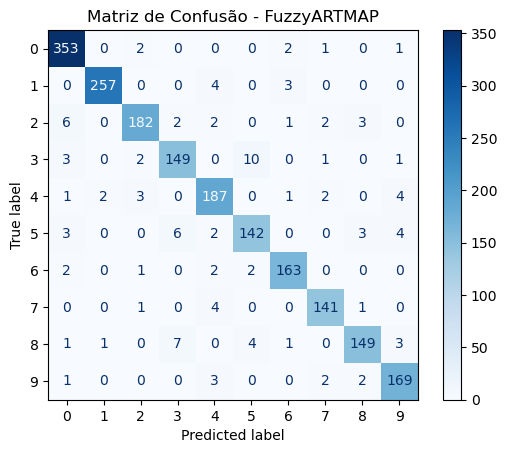

In [63]:
report = classification_report(y_test, fuzzy_artmap_predictions)
matrix = confusion_matrix(y_test, fuzzy_artmap_predictions)

print("\nClassification report:")
print(report)

cm = confusion_matrix(y_test, fuzzy_artmap_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - FuzzyARTMAP")
plt.show()

Com um rho mais alto, o desempenho foi melhorando!

## Testando função com métricas

In [51]:
acc_matrix = generate_acc_matrix_fuzzyARTMAP(num_tasks, X_train_sorted, y_train_sorted, 
                                            X_test_sorted, y_test_sorted, 1)

In [52]:
print(acc_matrix)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9916434540389972, 0.9886363636363636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9860724233983287, 0.9886363636363636, 0.9494949494949495, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9860724233983287, 0.9886363636363636, 0.9393939393939394, 0.9397590361445783, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9860724233983287, 0.9810606060606061, 0.9343434343434344, 0.9397590361445783, 0.96, 0.0, 0.0, 0.0, 0.0, 0.0], [0.9860724233983287, 0.9810606060606061, 0.9343434343434344, 0.8795180722891566, 0.96, 0.8875, 0.0, 0.0, 0.0, 0.0], [0.9860724233983287, 0.9734848484848485, 0.9292929292929293, 0.8795180722891566, 0.955, 0.88125, 0.9411764705882353, 0.0, 0.0, 0.0], [0.9832869080779945, 0.9734848484848485, 0.9242424242424242, 0.8795180722891566, 0.94, 0.88125, 0.9411764705882353, 0.9455782312925171, 0.0, 0.0], [0.9832869080779945, 0.9734848484848485, 0.9242424242424242, 0.8674698795180723, 0.935, 0.88125, 0.9411764705882353, 0.9319727891156463, 0.88554216

In [53]:
acc_matrix_df = pd.DataFrame(acc_matrix)

print(acc_matrix_df)

          0         1         2         3      4        5         6         7  \
0  1.000000  0.000000  0.000000  0.000000  0.000  0.00000  0.000000  0.000000   
1  0.991643  0.988636  0.000000  0.000000  0.000  0.00000  0.000000  0.000000   
2  0.986072  0.988636  0.949495  0.000000  0.000  0.00000  0.000000  0.000000   
3  0.986072  0.988636  0.939394  0.939759  0.000  0.00000  0.000000  0.000000   
4  0.986072  0.981061  0.934343  0.939759  0.960  0.00000  0.000000  0.000000   
5  0.986072  0.981061  0.934343  0.879518  0.960  0.88750  0.000000  0.000000   
6  0.986072  0.973485  0.929293  0.879518  0.955  0.88125  0.941176  0.000000   
7  0.983287  0.973485  0.924242  0.879518  0.940  0.88125  0.941176  0.945578   
8  0.983287  0.973485  0.924242  0.867470  0.935  0.88125  0.941176  0.931973   
9  0.983287  0.973485  0.924242  0.861446  0.920  0.85625  0.941176  0.897959   

          8         9  
0  0.000000  0.000000  
1  0.000000  0.000000  
2  0.000000  0.000000  
3  0.000000 

In [54]:
print(f"Forward transfer: {forward_transfer(num_tasks, acc_matrix):.6f}")
print(f"Backward transfer: {backward_transfer(num_tasks, acc_matrix):.6f}")
print(f"Average Accuracy: {average_accuracy(num_tasks, acc_matrix):.6f}")


Forward transfer: 0.000000
Backward transfer: -0.018544
Average Accuracy: 0.768026
